In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
bitcoin_data=pd.read_csv('C:/Users/lizheng/Documents/PythonScripts/candles.csv', sep=',')

#create some more features for the LSTM (long short term memory) model: 
#bt_close_high_gap represents the gap between the closing price and price high for that day

kwargs={'btc_close_high_gap': lambda x: (x['High']- x['Close'])/(x['High']-x['Low'])-1,
            'btc_volatility': lambda x: (x['High']- x['Low'])/(x['Open']) }
bitcoin_info = bitcoin_data.assign(**kwargs) #Assign new columns to a DataFrame with function assign()

#select the columns from bitcoin_info to model
model_data=bitcoin_info[['Close','btc_close_high_gap','btc_volatility','Volume','dates']]
type(model_data['dates'].iloc[1]) #the value of column 'dates' is a string

#convert the date string to a correct date format
model_data['dates']=pd.to_datetime(model_data['dates'])
#type(model_data['dates'].iloc[1]) check again the type of the value in the column 'dates'

#see the structure of the model_data : close and volume are not normalised
model_data.head()
model_data.tail()
model_data['btc_close_high_gap'].max()
model_data['btc_close_high_gap'].min()


C:\Users\lizheng\Anaconda3\envs\mypython3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


-1.0

In [4]:
# In time series models, we generally train on one period of time and then test on another separate period
# choose the split date 
split_date='2020-01-01'
# split the dateset 
training_set, test_set =model_data[model_data['dates']<split_date], model_data[model_data['dates']>=split_date]
# drop column 'dates' that we don't need for modeling 
training_set=training_set.drop('dates', 1 )
test_set=test_set.drop( 'dates', 1 )
#construct the training inputs and outputs and normalise the data
norms_volume_close=['Volume', 'Close']
lag = 7
LSTM_training_inputs = []
for i in range(len(training_set)-lag):
    temp_set = training_set[i:(i+lag)].copy()
    for col in norms_volume_close:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1#we normalise the close price locally under its window
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][lag:].values/training_set['Close'][:-lag].values)-1

#LSTM test inputs and outputs
LSTM_test_inputs = []
for i in range(len(test_set)-lag):
    temp_set = test_set[i:(i+lag)].copy()
    for col in norms_volume_close:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][lag:].values/test_set['Close'][:-lag].values)-1


In [5]:
#We would rather use numpy than pandas when all the datas are numeric : LSTM requires 3-D array
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [6]:
# import the relevant Keras modules

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#to build a model : firtstly, making an object of sequential model
#secondly add the lstm layers with parametrers
#input_shape: the shape of the training set
#Droupout layer is a type of regularization technique which is used to prevent overfitting

#generally people define a build_model function for conducting the LSTM model with its different layers



In [10]:
#to build a model : firtstly, making an object of sequential model
#secondly add the lstm layers with parametrers
#input_shape: the shape of the training set
#Droupout layer is a type of regularization technique which is used to prevent overfitting

#generally people define a build_model function for conducting the LSTM model with its different layers

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.15, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

Train on 184 samples
Epoch 1/60
184/184 - 2s - loss: 0.0828
Epoch 2/60
184/184 - 0s - loss: 0.0630
Epoch 3/60
184/184 - 0s - loss: 0.0535
Epoch 4/60
184/184 - 1s - loss: 0.0497
Epoch 5/60
184/184 - 1s - loss: 0.0443
Epoch 6/60
184/184 - 1s - loss: 0.0417
Epoch 7/60
184/184 - 1s - loss: 0.0411
Epoch 8/60
184/184 - 0s - loss: 0.0334
Epoch 9/60
184/184 - 0s - loss: 0.0342
Epoch 10/60
184/184 - 0s - loss: 0.0348
Epoch 11/60
184/184 - 0s - loss: 0.0365
Epoch 12/60
184/184 - 0s - loss: 0.0336
Epoch 13/60
184/184 - 1s - loss: 0.0340
Epoch 14/60
184/184 - 0s - loss: 0.0338
Epoch 15/60
184/184 - 0s - loss: 0.0320
Epoch 16/60
184/184 - 0s - loss: 0.0312
Epoch 17/60
184/184 - 0s - loss: 0.0318
Epoch 18/60
184/184 - 1s - loss: 0.0288
Epoch 19/60
184/184 - 1s - loss: 0.0320
Epoch 20/60
184/184 - 1s - loss: 0.0300
Epoch 21/60
184/184 - 1s - loss: 0.0272
Epoch 22/60
184/184 - 0s - loss: 0.0291
Epoch 23/60
184/184 - 0s - loss: 0.0302
Epoch 24/60
184/184 - 0s - loss: 0.0294
Epoch 25/60
184/184 - 0s - l

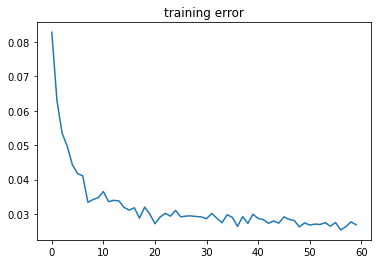

In [11]:
#ramdom seed (Is it important that number of seed??)
np.random.seed(0)
#initialise the model
btc_model=build_model(LSTM_training_inputs,output_size=1,neurons=20)
# model output is next price normalised to 7th previous closing price
LSTM_training_outputs = (training_set['Close'][lag:].values/training_set['Close'][:-lag].values)-1
# train model on data
# note: btc_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=60, batch_size=1, verbose=2, shuffle=True)
# If things go as planning, we are expecting that the errors are decreasing with epoch
# we plot the errors with the epoches (training iterations)
fig, ax = plt.subplots()
ax.plot(btc_history.epoch, btc_history.history['loss'])
ax.set_title("training error")
plt.show()

In [18]:
#calculate MAE (mean absolute error) : one of the many metrics for summarizing and-- 
#assessing the quality of a machine learning model
MAE=np.mean(np.abs((np.transpose(btc_model.predict(LSTM_training_inputs))+1)-
            (training_set['Close'].values[lag:])/(training_set['Close'].values[:-lag])))
print(MAE)

0.02575118335248768


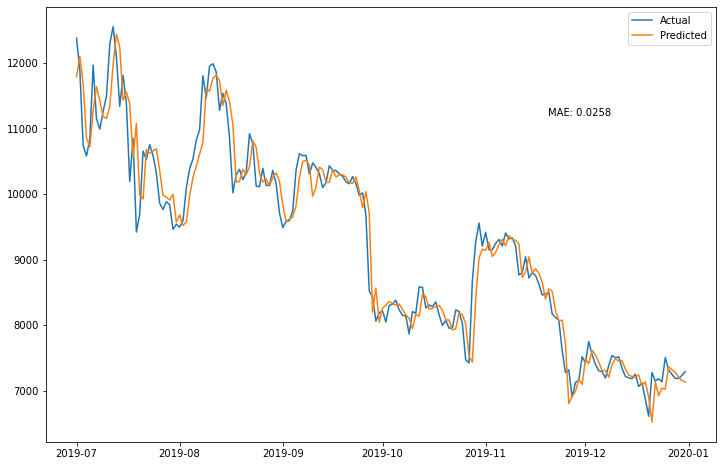

In [19]:
#plot the actual and predicted price with training data
import datetime
#take the predicted price bacl to its original scale to plot
price_pred=((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-lag])[0]
fig, ax1 = plt.subplots(figsize=(12,8))
#ax1.set_xticks([datetime.date(i,j,4) for i in range(2019,2020) for j in [1, 5, 11]]) #how to show the dates in the plot
#ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y') for i in range(2019,2020) for j in [1, 5, 11]])
ax1.plot(model_data[model_data['dates']< split_date]['dates'][lag:], training_set['Close'][lag:], label='Actual')
ax1.plot(model_data[model_data['dates']< split_date]['dates'][lag:], price_pred, label='Predicted')
ax1.annotate('MAE: %.4f'%MAE, xy=(0.75, 0.75),  xycoords='axes fraction')#The point (x, y) to annotate and the coordinate system is determined by xycoords.

ax1.legend() # even though we have already configured the label in ax1.plot, we must to give ax1.legend to show the legends in the plot.

plt.show()


0.026759303770364434


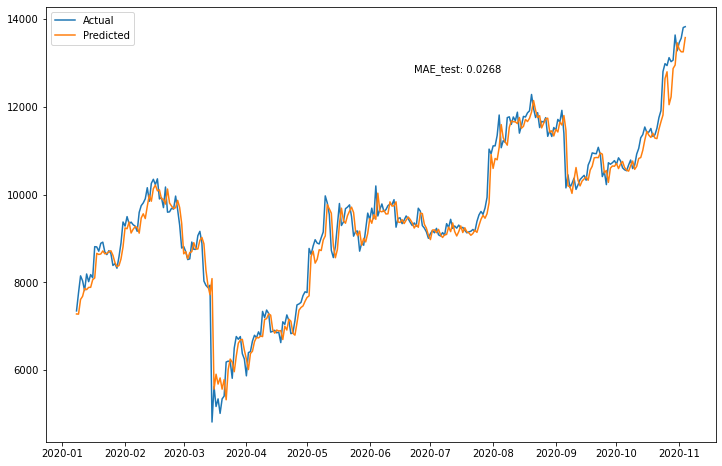

In [20]:
#calculate and plot the performance of test dataset
yhat=btc_model.predict(LSTM_test_inputs)
yhat.shape #(299,1)
#yhat contains the predicted values based on the model we constructed, the values od it are normalised. 
#we need to convert the values of yhat into the "non-normalised" values to compare with the true close price then.
y_converted=((np.transpose(yhat)+1)*test_set['Close'].values[:-lag])[0]
np.transpose(yhat).shape #(1,299) still a 2-D array
y_converted.shape #(299,) a 1-D array that is allowed by matplotlib

#calculate the MAE
# MAE_test=np.mean(np.abs(y_converted-test_set['Close'].values[window_len:])) result: 318.2870079121582
MAE_test=np.mean(np.abs((np.transpose(btc_model.predict(LSTM_test_inputs))+1)-
            (test_set['Close'].values[lag:])/(test_set['Close'].values[:-lag])))
print(MAE_test)

#plot the actual close price of test_setand the predicted close price
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(model_data[model_data['dates']>= split_date]['dates'][lag:], test_set['Close'][lag:], label='Actual')
ax1.plot(model_data[model_data['dates']>= split_date]['dates'][lag:],
         ((np.transpose(btc_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-lag])[0], 
         label='Predicted')
ax1.annotate('MAE_test: %.4f'%MAE_test, xy=(0.55, 0.85),  xycoords='axes fraction')#The point (x, y) to annotate and the coordinate system is determined by xycoords.

ax1.legend() # even though we have already configured the label in ax1.plot, we must to give ax1.legend to show the legends in the plot.

plt.show()


Some comments on the results: it seems that our model is not so bad at predicting the next-day close price with low MAE. Next we want to see if this model is good to predict the next 3 days of close price.

In [21]:
#Forcast the next 3 days of close price of the bitcoin
#random seed for reproductivity
np.random.seed(0)
#set the range of forcasting
y_span=3
#initialize the model 
btc_model_forcast=build_model(LSTM_training_inputs, output_size=y_span, neurons = 20)
#calculate the training outputs
LSTM_training_outputs = []
for i in range(lag, len(training_set['Close'])-y_span):
    LSTM_training_outputs.append((training_set['Close'][i:i+y_span].values/
                                  training_set['Close'].values[i-lag])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)

#fit the model based on training data set thus obtain the information of training error of each epoch
btc_history=btc_model_forcast.fit(LSTM_training_inputs[:-y_span], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
#type(LSTM_training_inputs)
#LSTM_training_inputs.shape
#LSTM_training_inputs[:-y_span].shape


Train on 181 samples
Epoch 1/50
181/181 - 2s - loss: 0.0776
Epoch 2/50
181/181 - 1s - loss: 0.0644
Epoch 3/50
181/181 - 1s - loss: 0.0553
Epoch 4/50
181/181 - 1s - loss: 0.0529
Epoch 5/50
181/181 - 1s - loss: 0.0497
Epoch 6/50
181/181 - 0s - loss: 0.0472
Epoch 7/50
181/181 - 1s - loss: 0.0448
Epoch 8/50
181/181 - 1s - loss: 0.0452
Epoch 9/50
181/181 - 0s - loss: 0.0425
Epoch 10/50
181/181 - 0s - loss: 0.0422
Epoch 11/50
181/181 - 0s - loss: 0.0429
Epoch 12/50
181/181 - 0s - loss: 0.0406
Epoch 13/50
181/181 - 0s - loss: 0.0402
Epoch 14/50
181/181 - 0s - loss: 0.0399
Epoch 15/50
181/181 - 1s - loss: 0.0396
Epoch 16/50
181/181 - 0s - loss: 0.0400
Epoch 17/50
181/181 - 1s - loss: 0.0409
Epoch 18/50
181/181 - 1s - loss: 0.0383
Epoch 19/50
181/181 - 1s - loss: 0.0380
Epoch 20/50
181/181 - 1s - loss: 0.0400
Epoch 21/50
181/181 - 0s - loss: 0.0389
Epoch 22/50
181/181 - 0s - loss: 0.0384
Epoch 23/50
181/181 - 0s - loss: 0.0376
Epoch 24/50
181/181 - 0s - loss: 0.0384
Epoch 25/50
181/181 - 0s - l

dict_keys(['loss'])


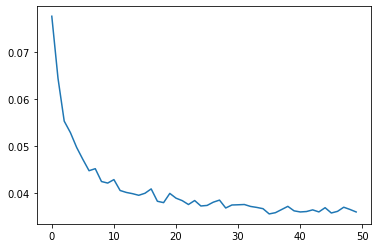

In [23]:
##detailed infos on the history object
type(btc_history)
#The history object is returned from calls to the fit() function used to train the model.
#Metrics are stored in a dictionary in the history member of the object returned
#for more information on history objet: you can refer to https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(btc_history.history.keys()) #dict_keys(['loss'])
#plot the metric 'loss' along with 'epoch'
plt.plot(btc_history.epoch, btc_history.history['loss'])
plt.show()

In [39]:
#the normalised outputs based on the test data set
outputs_pred_norm=btc_model_forcast.predict(LSTM_test_inputs[:-y_span])
#check the type and formats of the outputs(3 consecutives values)
price_pred_norm.shape
type(price_pred_norm)
price_pred_norm[:7]

#try to get the consecutive predicted normalised close price
price_pred_norm=outputs_pred_norm[::y_span]
#print(price_pred_norm)
price_pred_norm.shape

#denormalize the price_pred_norm by adding 1 and mutiplying its 10 previous close price in the original test set
price_pred_denorm=(price_pred_norm+1)*test_data['Close'].values[:-10][::3]
price_pred_denorm[:3]

array([[1.0758182, 1.0786357, 1.0644057],
       [1.122357 , 1.1325178, 1.1094112],
       [1.0776539, 1.0692229, 1.0681648]], dtype=float32)

In [40]:
test_set['Close'].values

array([ 7386.61,  7222.28,  7170.33,  7180.4 ,  6946.19,  7340.88,
        7349.66,  7351.16,  7766.3 ,  8150.  ,  8037.5 ,  7814.89,
        8192.62,  8017.68,  8178.63,  8104.84,  8815.17,  8810.  ,
        8711.81,  8892.2 ,  8917.79,  8696.  ,  8634.13,  8724.29,
        8659.19,  8386.66,  8428.57,  8324.13,  8585.29,  8898.22,
        9377.56,  9284.08,  9500.  ,  9336.69,  9374.7 ,  9314.79,
        9283.31,  9165.31,  9598.02,  9750.89,  9811.75,  9906.3 ,
       10158.61,  9849.21, 10257.9 , 10350.46, 10227.94, 10361.25,
        9902.92,  9936.08,  9705.  , 10174.64,  9600.77,  9608.3 ,
        9690.48,  9671.81,  9968.03,  9658.42,  9308.09,  8782.83,
        8817.95,  8701.18,  8521.  ,  8537.8 ,  8920.91,  8755.24,
        8753.52,  9066.23,  9164.48,  8892.93,  8031.77,  7933.96,
        7882.44,  7936.42,  4819.12,  5628.34,  5173.13,  5346.66,
        5016.4 ,  5346.54,  5410.96,  6186.43,  6206.72,  6198.68,
        5815.9 ,  6505.54,  6767.68,  6704.95,  6766.66,  6374

In [41]:
type(test_set['Close'])

pandas.core.series.Series

In [42]:
type(test_set['Close'].values)

numpy.ndarray

In [43]:
test_set['Close'].values.shape

(309,)